# <b>Tomato Plant Disease Detection Model<b>

#### Importing Required Libraries

In [66]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_model_optimization as tfmot


##### Defining all Hyperparameters

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=10

### <b>Stage 1: Data Preprocessing and Exploration</b>

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[0 2 4 6 0 7 9 6 6 7 4 7 1 1 0 7 0 7 0 9 0 5 7 2 1 4 7 9 9 1 2 5]


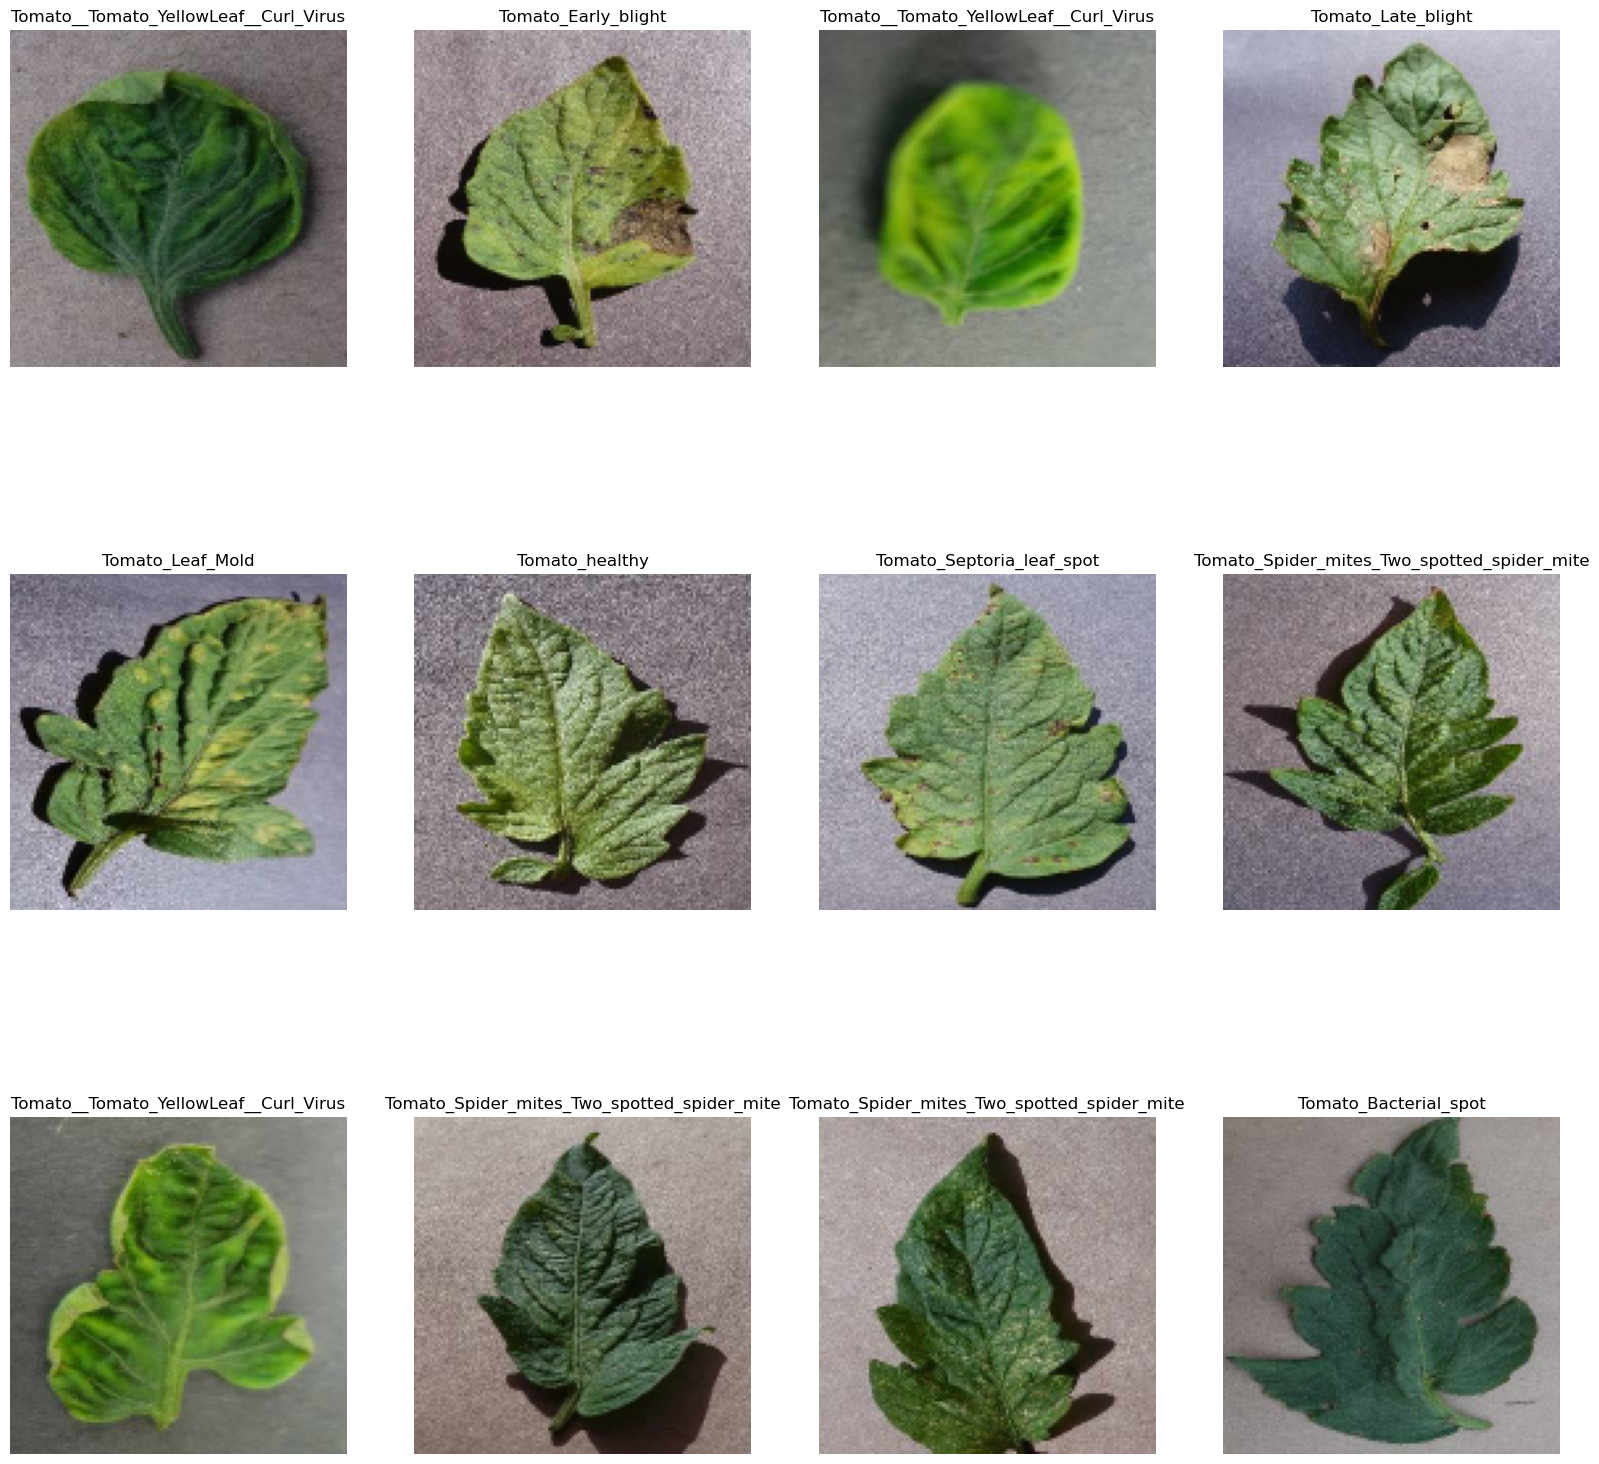

In [7]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

##### <b>Function to Split Dataset</b>
Dataset should be bifurcated into 3 subsets:
<ol>
<li>Training: Dataset to be used while training (80%)</li>
<li>Validation: Dataset to be tested against while training (10%)</li>
<li>Test: Dataset to be tested against after we trained a model (10%)</li>
<ol>

In [8]:
len(dataset)

501

In [9]:
train_size = 0.8
len(dataset)*train_size

400.8

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

447

In [12]:
val_size=0.1
len(dataset)*val_size

50.1

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

441

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, 
            test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

400

In [18]:
len(val_ds)

50

In [19]:
len(test_ds)

51

#### Cache, Shuffle, and Prefetch the Dataset

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### Layer for Resizing and Normalization

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

#### Data Augmentation

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

### <b>Stage 2: Model Development</b>

#### Model Architecture

In [27]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [28]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (32, 63, 63, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 30, 30, 64)          0         
 g2D)                                                 

#### Compiling the Model

In [29]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10


400/400 [==============================] - 75s 177ms/step - loss: 1.1369 - accuracy: 0.6125 - val_loss: 1.2958 - val_accuracy: 0.5525
Epoch 2/10
400/400 [==============================] - 66s 165ms/step - loss: 0.6070 - accuracy: 0.7867 - val_loss: 0.4716 - val_accuracy: 0.8288
Epoch 3/10
400/400 [==============================] - 68s 170ms/step - loss: 0.4699 - accuracy: 0.8393 - val_loss: 0.6809 - val_accuracy: 0.7644
Epoch 4/10
400/400 [==============================] - 68s 171ms/step - loss: 0.4053 - accuracy: 0.8590 - val_loss: 0.3247 - val_accuracy: 0.8881
Epoch 5/10
400/400 [==============================] - 68s 169ms/step - loss: 0.3688 - accuracy: 0.8737 - val_loss: 0.3901 - val_accuracy: 0.8744
Epoch 6/10
400/400 [==============================] - 70s 175ms/step - loss: 0.3421 - accuracy: 0.8855 - val_loss: 0.3715 - val_accuracy: 0.8637
Epoch 7/10
400/400 [==============================] - 72s 181ms/step - loss: 0.3106 - accuracy: 0.8922 - val_loss: 0.8885 - val_accuracy: 0.7

In [31]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 9s 38ms/step - loss: 0.2952 - accuracy: 0.8964


In [32]:
scores

[0.2952035367488861, 0.8964460492134094]

#### Plotting the Accuracy and Loss Curves

In [83]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

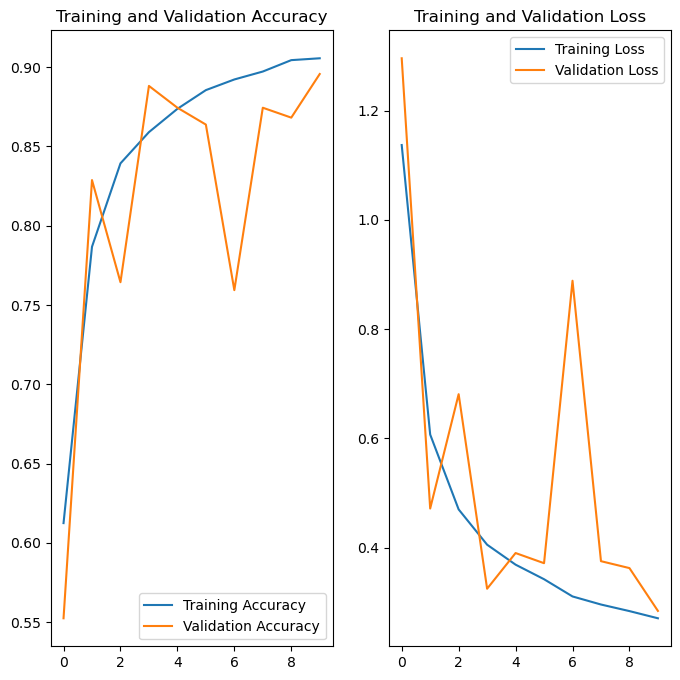

In [84]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
import os
model_version=max([int(i) for i in os.listdir("model") + [0]])+1
model.save(f"model/{model_version}")

INFO:tensorflow:Assets written to: model/1\assets


INFO:tensorflow:Assets written to: model/1\assets


In [54]:
keras_model = "tomato.h5"
model.save(keras_model)

C:\Users\its_y\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### <b>Stage 3: Model Conversion and Deployment</b>

#### Convert saved model to tf lite

In [55]:
tlm = "tf_lite_model.tflite"

In [59]:
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = tf_lite_converter.convert()

INFO:tensorflow:Assets written to: C:\Users\its_y\AppData\Local\Temp\tmpqg3nqpmv\assets


INFO:tensorflow:Assets written to: C:\Users\its_y\AppData\Local\Temp\tmpqg3nqpmv\assets


In [60]:
tflite_model_name = tlm
open(tflite_model_name, "wb").write(tflite_model)

3716336

In [37]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [38]:
input_details

[{'name': 'serving_default_sequential_input:0',
  'index': 0,
  'shape': array([  1, 128, 128,   3]),
  'shape_signature': array([ -1, 128, 128,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [39]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 19,
  'shape': array([ 1, 10]),
  'shape_signature': array([-1, 10]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [40]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [41]:
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [42]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [43]:
count = 0
for image, label in test_ds.take(5):
    print(label)
    
print(count)

tf.Tensor([7 4 5 6 3 9 4 7 2 1 3 0 0 4 7 5 7 0 2 7 2 0 5 7 7 7 2 2 7 7 2 4], shape=(32,), dtype=int32)
tf.Tensor([3 4 7 7 1 3 0 2 0 2 0 3 7 5 2 1 1 1 0 0 7 7 4 1 3 7 0 7 9 0 8 8], shape=(32,), dtype=int32)
tf.Tensor([0 7 7 2 6 2 9 3 7 2 3 4 2 9 2 4 3 4 4 7 9 3 2 2 2 7 6 4 5 6 1 6], shape=(32,), dtype=int32)
tf.Tensor([3 0 7 3 7 7 0 4 7 2 4 4 1 0 1 6 6 7 3 5 9 8 8 7 4 9 4 7 1 9 5 3], shape=(32,), dtype=int32)
tf.Tensor([4 4 0 3 0 7 3 6 6 7 4 9 9 0 9 1 7 3 6 2 5 2 6 0 7 5 7 6 7 5 0 6], shape=(32,), dtype=int32)
0


In [44]:
for image, label in test_ds.unbatch().take(5):
    print("image shape",image.shape)
    print("label",label)

image shape (128, 128, 3)
label tf.Tensor(4, shape=(), dtype=int32)
image shape (128, 128, 3)
label tf.Tensor(2, shape=(), dtype=int32)
image shape (128, 128, 3)
label tf.Tensor(6, shape=(), dtype=int32)
image shape (128, 128, 3)
label tf.Tensor(2, shape=(), dtype=int32)
image shape (128, 128, 3)
label tf.Tensor(9, shape=(), dtype=int32)


In [47]:
for image, label in test_ds.unbatch().take(5):
    interpreter.set_tensor(input_index, [image.numpy().astype(np.float32)])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)

In [48]:
predicted_labels = []
actual_labels = []

for image, label in test_ds.unbatch():
    interpreter.set_tensor(input_index, [image])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)
    predicted_labels.append(np.argmax(output[0]))
    actual_labels.append(label.numpy())

In [49]:
predicted_labels[:10]

[5, 0, 0, 7, 3, 7, 6, 4, 8, 5]

In [50]:
actual_labels[:10]

[5, 0, 0, 7, 3, 7, 6, 4, 8, 5]

In [51]:
comparison_vector = np.array(predicted_labels) == np.array(actual_labels)
comparison_vector[:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [52]:
np.array([True,False,True]).mean()

0.6666666666666666

In [53]:
accuracy = comparison_vector.mean()
accuracy

0.8964460784313726

#### Quantization Aware Model

In [67]:
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [68]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 quant_conv2d_2 (QuantizeWr  (None, 126, 126, 32)      963       
 apperV2)                                                        
                                                                 
 quant_max_pooling2d_2 (Qua  (None, 63, 63, 32)        1         
 ntizeWrapperV2)                                                 
                                                                 
 quant_conv2d_3 (QuantizeWr  (None, 61, 61, 64)        18627     
 apperV2)                                                        
                                                      

In [69]:
quant_aware_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [71]:
q_history = quant_aware_model.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/10


400/400 [==============================] - 106s 260ms/step - loss: 0.3255 - accuracy: 0.8900 - val_loss: 0.3045 - val_accuracy: 0.8881
Epoch 2/10
400/400 [==============================] - 96s 240ms/step - loss: 0.2557 - accuracy: 0.9137 - val_loss: 0.3406 - val_accuracy: 0.8813
Epoch 3/10
400/400 [==============================] - 98s 246ms/step - loss: 0.2461 - accuracy: 0.9162 - val_loss: 0.5507 - val_accuracy: 0.8244
Epoch 4/10
400/400 [==============================] - 96s 239ms/step - loss: 0.2213 - accuracy: 0.9223 - val_loss: 0.3667 - val_accuracy: 0.8825
Epoch 5/10
400/400 [==============================] - 97s 243ms/step - loss: 0.2025 - accuracy: 0.9283 - val_loss: 0.2985 - val_accuracy: 0.9000
Epoch 6/10
400/400 [==============================] - 103s 259ms/step - loss: 0.2067 - accuracy: 0.9272 - val_loss: 0.2610 - val_accuracy: 0.9119
Epoch 7/10
400/400 [==============================] - 103s 258ms/step - loss: 0.2164 - accuracy: 0.9272 - val_loss: 0.2780 - val_accuracy: 

In [72]:
print("[INFO] Calculating Quant Aware model accuracy")
scores = quant_aware_model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating Quant Aware model accuracy
51/51 [==============================] - 6s 108ms/step - loss: 0.3248 - accuracy: 0.8903
Test Accuracy: 89.03%


In [73]:
tlqm = "tf_lite_quantized_model.tflite"

In [78]:
tf_lite_quantized_model = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
tf_lite_quantized_model.optimizations = [tf.lite.Optimize.DEFAULT]
tf_lite_quantized_model.target_spec.supported_types = [tf.float16]
quantized_tflite_model = tf_lite_quantized_model.convert()

INFO:tensorflow:Assets written to: C:\Users\its_y\AppData\Local\Temp\tmprmo6t3uu\assets


INFO:tensorflow:Assets written to: C:\Users\its_y\AppData\Local\Temp\tmprmo6t3uu\assets
C:\Users\its_y\AppData\Roaming\Python\Python311\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [79]:
tf_lite_quantized_model = tlqm
open(tf_lite_quantized_model, "wb").write(quantized_tflite_model)

3716536

In [80]:
def evaluate_tflite_model(dataset, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []
    for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        test_labels.append(label)

    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_tflite_model(dataset, interpreter)

print('Quant TFLite test_accuracy:', test_accuracy)

Quant TFLite test_accuracy: 0.8908875148335519


### <b>Stage 4 : Evaluation and Validation</b>

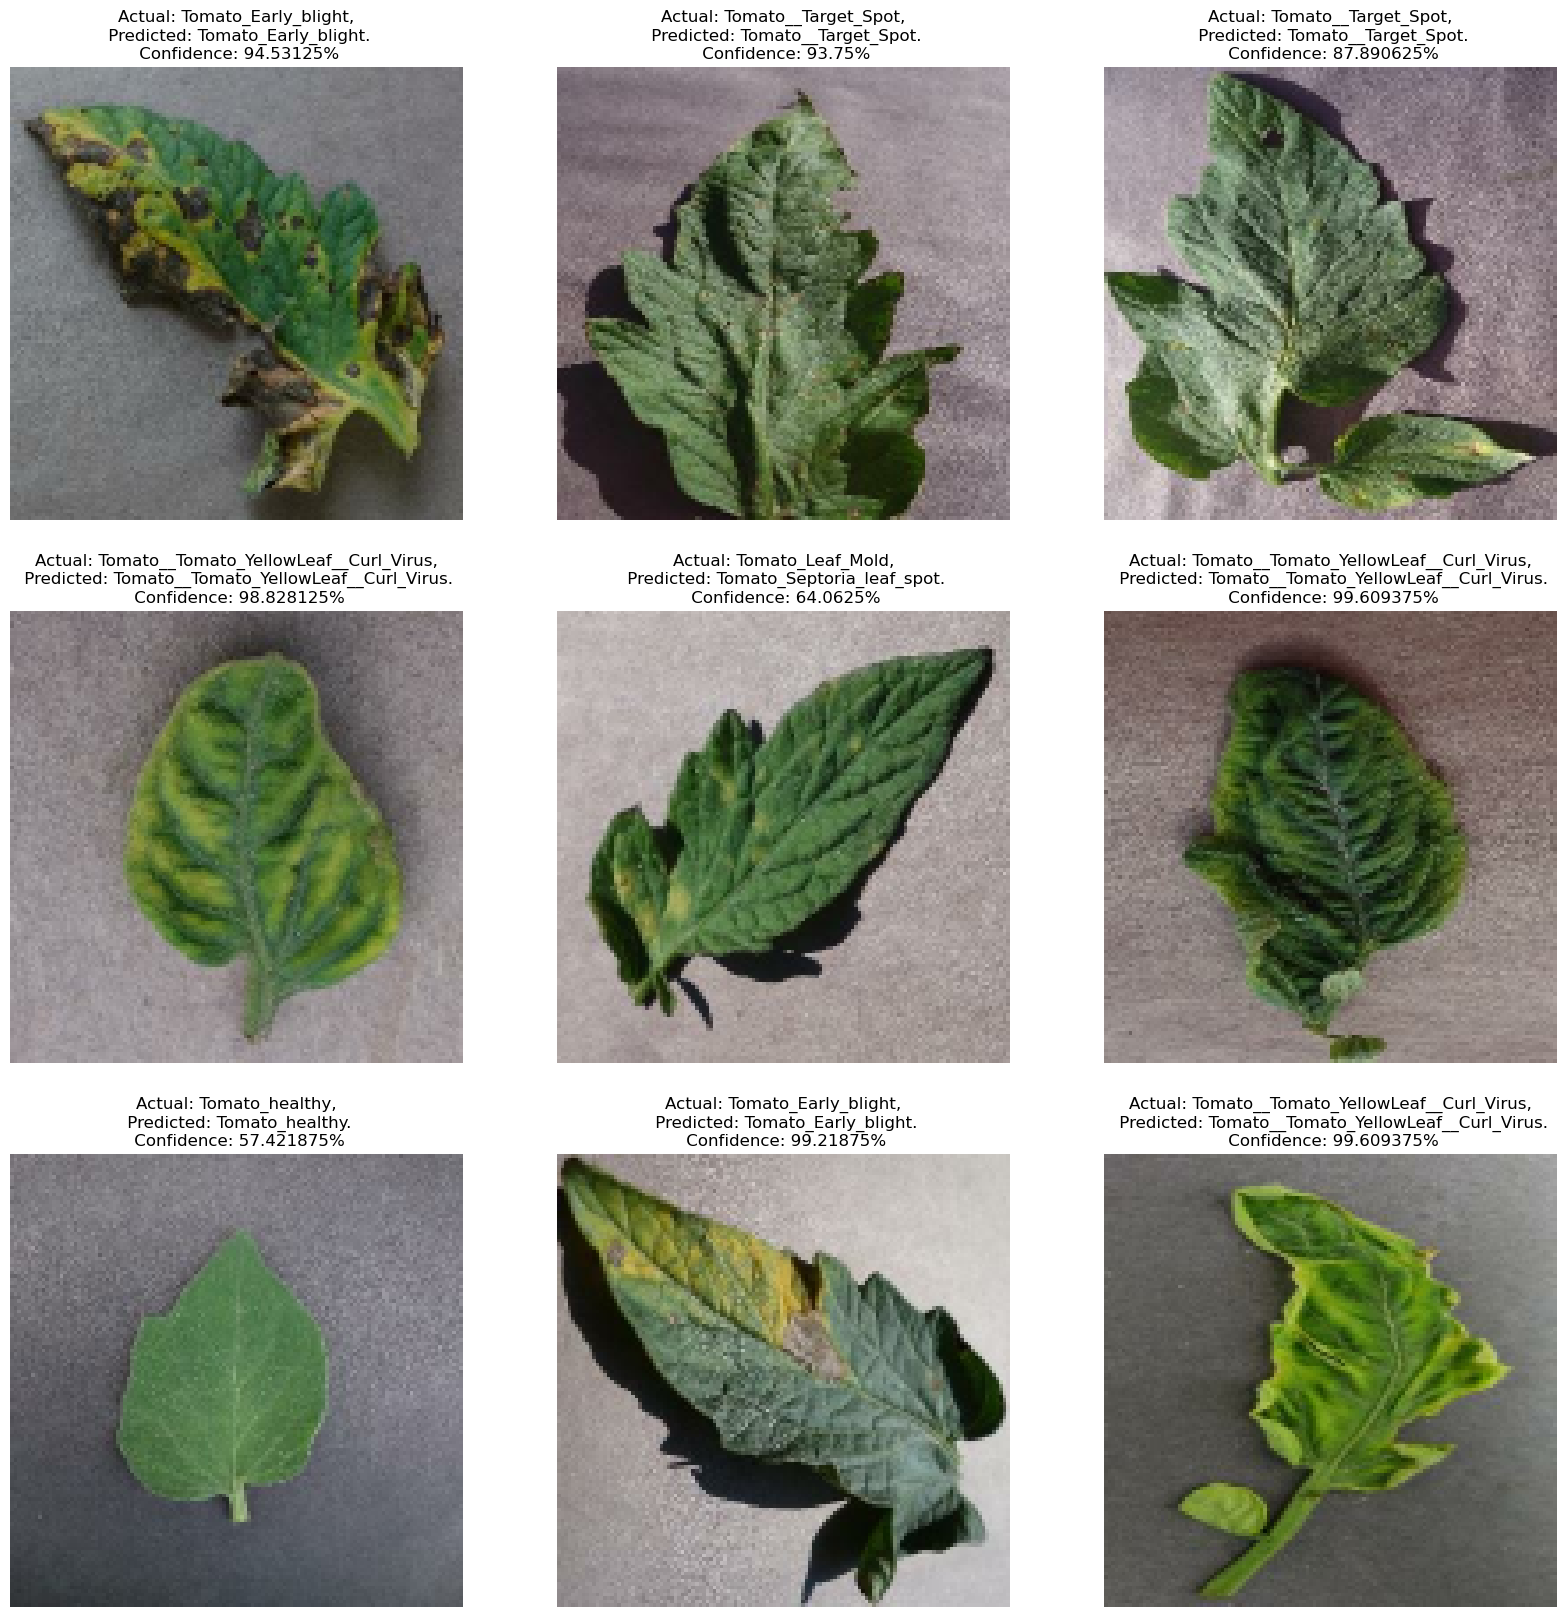

In [85]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        

        actual_class = class_names[labels[i]]

        test_image = np.expand_dims(images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])

        predicted_class = class_names[digit]
        confidence = np.max(output()[0])*100

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n 
                  Confidence: {confidence}%")
        plt.axis("off")